#### References

- https://www.sciencedirect.com/science/article/pii/S037722172300382X
- https://www.sciencedirect.com/science/article/pii/S2212827120307708
- https://www.researchgate.net/publication/388529112_Investigating_the_Monte-Carlo_Tree_Search_Approach_for_the_Job_Shop_Scheduling_Problem
- https://www.sciencedirect.com/science/article/pii/S2212827122001846
- https://www.honda-ri.de/pubs/pdf/3949.pdf
- https://www.youtube.com/watch?v=UXW2yZndl7U

#### Summary
- The client requires a model that would assign engineers to tasks such that all tasks are completed within the shortest time with deadlines being met
- This requirement is a variant of the Flexible Job Shop Scheduling problem
```
A "flexible job shop scheduling problem" (FJSP) is a variation of the classic job shop scheduling problem where each operation within a job can be processed on multiple machines, meaning you have the flexibility to choose which machine to use for each operation, requiring both assignment of operations to machines and sequencing of operations on those machines to optimize a chosen objective, like minimizing overall completion time
```
- Models currently being tried
  - Reinforcement Learning
    - Formulate reward function based on maximizing completion rate and minimizing makespan and overshooting deadlines
      - RL Techniques employed:
        - Q Learning
        - Monte Carlo Tree Search
  - Heuristic
    - Greedy
      - at each stage, choose the action from allowable actions that would result in the shortest makespan
- Pending
  - How to load and transform client data to the different python objects
  - Check performance on larger datasets
  - Hyperparameter tuning
  - Instead having only one completion time per task per worker, create function where the worker task completion time would be sampled from historical completion times

In [1]:
import pandas as pd

In [2]:
def melt_default_task(sheet_name):
    df1 = pd.read_excel('default_takt.xlsx', sheet_name=sheet_name)
    df_melted = df1.melt(id_vars='PRODUCT-ASSY TYPE',
                        var_name='Task',
                        value_name='Takt')
    df_melted = df_melted.dropna()
    df_melted['PRODUCT-ASSY TYPE'] = df_melted['PRODUCT-ASSY TYPE'].str.upper()
    df_melted['Task'] = df_melted['Task'].str.upper()
    return df_melted

df_melted = melt_default_task('Sheet1')
df_melted2 = melt_default_task('Sheet2')
df_melted3 = melt_default_task('Sheet3')
df_melted4 = melt_default_task('Sheet4')
df_all_melted = pd.concat([df_melted, df_melted2, df_melted3, df_melted4], ignore_index=True)

# Display the combined DataFrame
display(df_all_melted)

,PRODUCT-ASSY TYPE,Task,Takt
0,BGATSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
1,FPSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
2,LGATSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
3,OTQSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
4,QFNSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
...,...,...,...
3653,MOLDSERIESSOCKETPO,ASSY CHECKING,3.0
3654,OFFTHESHELFSOCKETPO,ASSY CHECKING,2.0
3655,AMSOCKETINQUIRY,ASSY CHECKING,8.0
3656,MOLDSERIESSOCKETINQUIRY,ASSY CHECKING,3.0


#### Q Learning

In [3]:
import numpy as np
import random

# Define the FJSP Environment
class FJSP_Env:
    def __init__(self, jobs, workers, processing_times, deadlines, 
                 switch_penalty=2, ongoing_tasks = None,
                 not_same_pic=None, heuristic='random'):
        self.jobs = jobs
        self.workers = workers
        self.processing_times = processing_times
        self.deadlines = deadlines
        self.switch_penalty = switch_penalty
        self.ongoing_tasks = ongoing_tasks
        self.not_same_pic = not_same_pic
        self.reset()

    def create_copy(self):
        env_copy = FJSP_Env(
            jobs=self.jobs,
            workers=self.workers,
            processing_times=self.processing_times,
            deadlines=self.deadlines,
            switch_penalty=self.switch_penalty,
            ongoing_tasks=self.ongoing_tasks,
            not_same_pic = self.not_same_pic
        )
        env_copy.schedule = list(self.schedule)
        env_copy.completed_jobs = set(self.completed_jobs)
        env_copy.worker_time = dict(self.worker_time)
        env_copy.worker_last_job = dict(self.worker_last_job)
        env_copy.current_time = self.current_time
        env_copy.task_assignments = dict(self.task_assignments)
        return env_copy
    
    def prioritize_ongoing_tasks(self):
        '''Set ongoing tasks first in the scheduler'''
        if self.ongoing_tasks is not None:
            for job, sub_job, worker, process_time in self.ongoing_tasks:
                start_time = self.worker_time[worker]
            
                last_finished_job_time = max(
                    (end for j, _, _, _, end in self.schedule if j == job),
                    default=0
                )
                if last_finished_job_time > start_time:
                    start_time = last_finished_job_time
                        
                finish_time = start_time + process_time
                self.worker_time[worker] = finish_time
                self.worker_last_job[worker] = job
            
                self.schedule.append((job, sub_job, worker, start_time, finish_time))
                self.completed_jobs.add(sub_job)
                self.current_time = max(self.worker_time.values())

                self.task_assignments[sub_job] = worker
            
    
    def reset(self):
        self.schedule = []
        self.completed_jobs = set()
        self.worker_time = {worker: 0 for worker in self.workers}
        self.worker_last_job = {worker: None for worker in self.workers}
        self.current_time = 0
        self.task_assignments = {}
        self.prioritize_ongoing_tasks()        
        return self.get_state()

    def previous_task_done(self, job, sub_job):
        if sub_job in self.completed_jobs:
            return False

        job_sequence = self.jobs[job]
        sub_job_index = job_sequence.index(sub_job)

        if sub_job_index > 0:
            required_sub_jobs = job_sequence[:sub_job_index]
            if any(req_sub not in self.completed_jobs for req_sub in required_sub_jobs):
                return False

        return True

    def get_tasks_for_assignment(self):
        tasks = [
            (job, sub_job)
            for job, sub_jobs in self.jobs.items()
            for sub_job in sub_jobs
            if self.previous_task_done(job, sub_job)
        ]
        return tasks

    
    def is_valid_action(self, job, sub_job, worker):
        if sub_job in self.completed_jobs:
            return False

        if worker not in self.processing_times.get(sub_job, {}):
            return False

        job_sequence = self.jobs[job]
        sub_job_index = job_sequence.index(sub_job)

        if sub_job_index > 0:
            required_sub_jobs = job_sequence[:sub_job_index]
            if any(req_sub not in self.completed_jobs for req_sub in required_sub_jobs):
                return False
                
        if self.not_same_pic and sub_job in self.not_same_pic:
            prev_task = self.not_same_pic[sub_job]
            prev_worker = self.task_assignments.get(prev_task)
            if prev_worker == worker:
                return False
                
        return True

    def get_possible_actions(self):
        actions = [
            (job, sub_job, worker)
            for job, sub_jobs in self.jobs.items()
            for sub_job in sub_jobs
            for worker in self.workers
            if self.is_valid_action(job, sub_job, worker)
        ]
        return actions

    def step(self, action):
        if action is None or len(action) != 3:
            return self.get_state(), -100, True
    
        job, sub_job, worker = action
        if not self.is_valid_action(job, sub_job, worker):
            return self.get_state(), -10, False
    
        process_time = self.processing_times[sub_job][worker]
        start_time = self.worker_time[worker]
    
        last_finished_job_time = max(
            (end for j, _, _, _, end in self.schedule if j == job),
            default=0
        )
        if last_finished_job_time > start_time:
            start_time = last_finished_job_time
    
        switching = self.worker_last_job[worker] is not None and self.worker_last_job[worker] != job
        if switching:
            start_time += self.switch_penalty
    
        finish_time = start_time + process_time
        self.worker_time[worker] = finish_time
        self.worker_last_job[worker] = job
    
        self.schedule.append((job, sub_job, worker, start_time, finish_time))
        self.completed_jobs.add(sub_job)
        self.current_time = max(self.worker_time.values())

        self.task_assignments[sub_job] = worker
    
        # Compute stats
        total_jobs = sum(len(subs) for subs in self.jobs.values())
    
        last_finish_times = {
            job: max((end for j, _, _, _, end in self.schedule if j == job), default=0)
            for job in self.jobs
        }
    
        overshoot_per_job = {
            job: max(0, last_finish_times[job] - self.deadlines[job])
            for job in self.jobs
        }
    
        total_overshoot = sum(overshoot_per_job.values())
    
        # Utilization: busy time / makespan
        makespan = self.current_time
        avg_busy_time = sum(self.worker_time.values()) / len(self.worker_time)
        utilization = avg_busy_time / makespan if makespan > 0 else 0
    
        # Reward
        reward = (
            -10.0 * makespan                   # minimize makespan
            - 10.0 * (1 - utilization)              # minimize idle time
            - 5.0 * total_overshoot           # penalize late jobs
            - 0.25*(self.switch_penalty if switching else 0)  # switching penalty
        )
    
        done = len(self.completed_jobs) == total_jobs
        return self.get_state(), reward, done

    def get_state(self):
        completed_vector = [
            1 if sub_job in self.completed_jobs else 0
            for job in self.jobs
            for sub_job in self.jobs[job]
        ]
        worker_loads = list(self.worker_time.values())
        return tuple(completed_vector + worker_loads)

import random
import matplotlib.pyplot as plt

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9,
                 epsilon=0.9, epsilon_min=0.1,
                 init_q_value=0.0, heuristic='random'):
        assert heuristic in ['random', 'makespan','reward'], "heuristic must be 'random','makespan', or 'reward'"
        
        self.heuristic = heuristic
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        self.init_q_value = init_q_value  # Set the initial Q-value for all state-action pairs
        self.epsilon_min = epsilon_min

    def get_state(self):
        # Compact, hashable state representation
        return (
            frozenset(self.env.completed_jobs),
            tuple(self.env.worker_time[w] for w in self.env.workers)
        )

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def get_action_best_makespan(self, actions):
        results = {}
        for action in actions:
            env_copy = self.env.create_copy()
            env_copy.step(action)
            results[action] = env_copy.current_time        
        return min(results, key=results.get)

    def get_action_best_reward(self, actions):
        results = {}
        for action in actions:
            env_copy = self.env.create_copy()
            _, reward, _ =env_copy.step(action)
            results[action] = reward
        return max(results, key=results.get)

    def choose_action(self, state, explore=True):
        actions = self.env.get_possible_actions()
        if not actions:
            return None
        if random.uniform(0, 1) < self.epsilon and explore:
            if self.heuristic == 'random':                    
                random_action = random.choice(actions)
                return random_action
            elif self.heuristic == 'makespan':
                return self.get_action_best_makespan(actions)
            elif self.heuristic == 'reward':
                return self.get_action_best_reward(actions)
        else:
            q_values = {action: self.get_q_value(state, action) for action in actions}            
            max_q = max(q_values.values())
            best_actions = [action for action, q in q_values.items() if q == max_q]
            best_action =  random.choice(best_actions)            
            return best_action

    def update_q_value(self, state, action, reward, next_state):
        best_next_q = max(
            [self.get_q_value(next_state, a) for a in self.env.get_possible_actions()],
            default=0
        )
        old_q = self.get_q_value(state, action)
        self.q_table[(state, action)] = old_q + self.alpha * (reward + self.gamma * best_next_q - old_q)
       

    def train(self, episodes=1000, log_every=10000):
        epsilon_decay = (self.epsilon_min / self.epsilon) ** (1 / episodes)
        
        self.training_rewards = []
        for ep in range(episodes):
            state = self.env.reset()
            state = self.get_state()
            done = False
            total_reward = 0
            # counter = 0
            while not done:
                # print(f"current state:{state}")
                
                action = self.choose_action(state)
                next_state_raw, reward, done = self.env.step(action)
                next_state = self.get_state()
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                # counter = counter + 1
                # if counter == 4:
                    # done = True

            self.training_rewards.append(total_reward)
            self.epsilon = max(self.epsilon_min, self.epsilon * epsilon_decay)

            if ep % log_every == 0:
                print(f"Episode {ep}: Total reward = {total_reward:.2f}")

    def get_best_schedule(self):
        state = self.env.reset()
        state = self.get_state()
        done = False
        total_reward = 0

        while not done:
            action = self.choose_action(state, False)
            if action is None:
                break
            _, reward, done = self.env.step(action)
            state = self.get_state()
            total_reward += reward

        return self.env.schedule, self.env.current_time


    
    def plot_rewards(self, window=50):
        if not self.training_rewards:
            print("No training data to plot.")
            return
        plt.figure(figsize=(10, 5))
        rewards = self.training_rewards
        smoothed = [sum(rewards[max(0, i - window):i + 1]) / (i - max(0, i - window) + 1)
                    for i in range(len(rewards))]
        plt.plot(rewards, label="Episode Reward", alpha=0.3)
        plt.plot(smoothed, label=f"Smoothed (window={window})", color="blue")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Q-Learning Training Progress")
        plt.legend()
        plt.grid(True)
        plt.show()


#### Load schedule and initialize environment

In [4]:
from catboost import CatBoostClassifier
import pandas as pd

df_projects = pd.read_excel("sample_schedule.xlsx", sheet_name="Sheet1")
df_pic_tasks = pd.read_excel("sample_schedule.xlsx", sheet_name="Sheet2")
df_skills = pd.read_excel('PIC_skills_edited.xlsx')

df_predict_takt = pd.merge(df_projects,df_pic_tasks, on='PRODUCT-ASSY TYPE Task', how='inner')
df_predict_takt = df_predict_takt.merge(df_skills, on='PIC', how='inner')
jobs = df_projects.groupby('PN', sort=False)['PN Task'].apply(list).to_dict()
workers = df_predict_takt['PIC'].unique()
workers = list(workers)
deadlines = {key: 100 for key in df_projects['PN'].unique()}

In [10]:
df_predict_takt.columns

Index(['PN', 'PRODUCT-ASSY TYPE', 'Task', 'PN Task', 'PRODUCT-ASSY TYPE Task',
       'ASSY TYPE', 'PARTS TYPE', 'ORDER TYPE', 'INQUIRY_OR_PO', 'Order Type',
       'NUM_SITE', 'NUM_STRIP', 'SITE_TYPE', 'PN_PREFIX', 'DeliveryDate',
       'PIC', 'JAGUAR', 'WCSP', 'STRIP', 'BI', 'TI', 'NON TI', 'Designation',
       'CadExp_Enplas', 'Enplas_Years', 'CADWork_NonEnplas', 'NonCadWork',
       'Total'],
      dtype='object')

#### Load model to get task completion times per engineer

In [12]:
from catboost import CatBoostClassifier

# Load model
catboost_model = CatBoostClassifier()
catboost_model.load_model("catboost_modelV2.cbm")

# Prepare data
df_ml_dataset = df_predict_takt[[
    'Task', 'ASSY TYPE', 'PARTS TYPE',
    'ORDER TYPE', 'SITE_TYPE','PN_PREFIX',
    'JAGUAR', 'WCSP', 'STRIP', 'BI', 'TI', 'NON TI',
    'Designation',
    'CadExp_Enplas', 'Enplas_Years', 'CADWork_NonEnplas',
    'NonCadWork', 'Total',
    'NUM_SITE', 'NUM_STRIP', "PIC"
]].copy()

#cat_cols = ['Task', 'ASSY TYPE', 'PARTS TYPE',
#            'ORDER TYPE', 'SITE_TYPE','PN_PREFIX',
#            'JAGUAR', 'WCSP', 'STRIP', 'BI', 'TI', 'NON TI','Designation']

cat_cols = ['Task', 'ASSY TYPE', 'PARTS TYPE',
            'ORDER TYPE', 'SITE_TYPE','PN_PREFIX',
            'Designation', 'PIC']

# Convert to categorical
for col in cat_cols:
    df_ml_dataset[col] = df_ml_dataset[col].astype('category')

# Debug: Check data integrity
if df_ml_dataset.empty:
    raise ValueError("Input DataFrame for prediction is empty.")

missing_cols = set(catboost_model.feature_names_) - set(df_ml_dataset.columns)
if missing_cols:
    raise ValueError(f"Missing features required by the model: {missing_cols}")

# Predict
predicted_takt = catboost_model.predict(df_ml_dataset, prediction_type="RawFormulaVal")

# Append to original DataFrame
df_predict_takt['Predicted Takt'] = predicted_takt


In [13]:
df_predict_takt.head(4)

,PN,PRODUCT-ASSY TYPE,Task,PN Task,PRODUCT-ASSY TYPE Task,ASSY TYPE,PARTS TYPE,ORDER TYPE,INQUIRY_OR_PO,Order Type,...,BI,TI,NON TI,Designation,CadExp_Enplas,Enplas_Years,CADWork_NonEnplas,NonCadWork,Total,Predicted Takt
0,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,DRAWING - 2D&3D ASSY,QFN-28X32EPK-0.5-001-DRAWING - 2D&3D ASSY,JAGUARSOCKETDIFFICULTPO-DRAWING - 2D&3D ASSY,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,0,0,0,ADE,3.0,11.0,0.0,0.0,11.0,7.793283
1,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,DRAWING - 2D&3D ASSY,QFN-28X32EPK-0.5-001-DRAWING - 2D&3D ASSY,JAGUARSOCKETDIFFICULTPO-DRAWING - 2D&3D ASSY,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,0,100,100,ADE,10.0,14.0,0.0,0.0,14.0,7.746169
2,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,DRAWING - 2D&3D ASSY,QFN-28X32EPK-0.5-001-DRAWING - 2D&3D ASSY,JAGUARSOCKETDIFFICULTPO-DRAWING - 2D&3D ASSY,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,100,85,0,DE,8.5,7.5,9.0,2.0,19.5,7.106845
3,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,DRAWING - 2D&3D ASSY,QFN-28X32EPK-0.5-001-DRAWING - 2D&3D ASSY,JAGUARSOCKETDIFFICULTPO-DRAWING - 2D&3D ASSY,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,0,0,0,DE,1.0,1.0,9.0,1.0,11.0,9.656152


In [10]:
df_all_melted.head(20)

,PRODUCT-ASSY TYPE,Task,Takt
0,BGATSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
1,FPSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
2,LGATSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
3,OTQSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
4,QFNSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
5,STRIPSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
6,WCSPSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
7,JAGUARSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
8,BGATLIDNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
9,FPLIDNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0


In [ ]:
SMARTSHEET_API_TOKEN = "wvPWOqoyipPIUdNIZD0IjyiERIRy6G57jxFd3"
#SHEET2_ID = "3c2cMpgC6cF3P2PGwc9Qpc4WH79Xr96P9jh4jmJ1"
SHEET1_ID = "XpGXJmRG3m6MMM68JWHChjGfPjHRRCjX2v64WX41"
#SHEET3_ID = "9hX8fHWcM8wMG86q5rvXPrHX64m7f5WrHmGP5Hf1"
#SHEET4_ID =  "Cchp54454CVwQP3cvwmRGf9WmMpQCCCPVpFw4F71"
TASK_SHEET_ID = "v28pj8J2Wm7hMJxC6fPMCc7Xfgxv3CCRHq9cf681"
SKILLS_SHEET_ID = "3F8rgj3vpQ83p4jxwRfHr66Jjh44F3CG637grJ91"


In [57]:
import pandas as pd
import smartsheet
import logging

# Configure basic logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def get_smartsheet_data(sheet_id: str, api_token: str) -> pd.DataFrame:
    """
    Retrieve data from a Smartsheet and convert to DataFrame
    
    Args:
        sheet_id (str): Unique identifier for the Smartsheet
        api_token (str): Smartsheet API token
    
    Returns:
        pd.DataFrame: DataFrame with sheet data
    """
    try:
        # Initialize client with API access token
        smart = smartsheet.Smartsheet(api_token)
        
        # Load the sheet
        sheet = smart.Sheets.get_sheet(sheet_id)
        
        # Extract column names
        columns = [col.title for col in sheet.columns]
        
        # Process rows
        rows = []
        for row in sheet.rows:
            cells = [
                cell.value if hasattr(cell, 'value') and cell.value is not None 
                else None 
                for cell in row.cells
            ]
            
            # Only append non-empty rows
            if any(cell is not None for cell in cells):
                rows.append(cells)
        
        # Create DataFrame
        df = pd.DataFrame(rows, columns=columns)
        
        logger.info(f"Successfully retrieved {len(df)} rows from sheet {sheet_id}")
        return df
    
    except Exception as e:
        logger.error(f"Error retrieving sheet {sheet_id}: {e}")
        raise

In [58]:
def melt_default_task(sheet_id: str, api_token: str) -> pd.DataFrame:
    """
    Melt Smartsheet data
    
    Args:
        sheet_id (str): Unique identifier for the Smartsheet
        api_token (str): Smartsheet API token
    
    Returns:
        pd.DataFrame: Melted DataFrame
    """
    # Retrieve sheet data
    df1 = get_smartsheet_data(sheet_id, api_token)
    
    # Identify value columns (exclude ID column)
    value_columns = [col for col in df1.columns if col != 'PRODUCT-ASSY TYPE']
    
    # Melt the DataFrame
    df_melted = df1.melt(
        id_vars=['PRODUCT-ASSY TYPE', 'PARTS TYPE'],
        var_name='Task',
        value_name='Takt',
        value_vars=value_columns
    )
    
    # Clean and standardize data
    df_melted = df_melted.dropna()
    df_melted['PRODUCT-ASSY TYPE'] = df_melted['PRODUCT-ASSY TYPE'].str.upper().str.strip()
    df_melted['Task'] = df_melted['Task'].str.upper().str.strip()
    
    return df_melted

In [59]:
df_melted = melt_default_task(SHEET1_ID, SMARTSHEET_API_TOKEN)

2025-05-19 13:46:33,587 - INFO - {"request": {"command": "GET https://api.smartsheet.com/2.0/sheets/XpGXJmRG3m6MMM68JWHChjGfPjHRRCjX2v64WX41"}}
2025-05-19 13:46:33,780 - INFO - Successfully retrieved 152 rows from sheet XpGXJmRG3m6MMM68JWHChjGfPjHRRCjX2v64WX41


In [60]:
df_melted.head(4)

,PRODUCT-ASSY TYPE,PARTS TYPE,Task,Takt
0,BGATSOCKETNEWINQUIRY,SOCKET,PN/PIN HOLE COUNT DETAILS,1.0
1,FPSOCKETNEWINQUIRY,SOCKET,PN/PIN HOLE COUNT DETAILS,0.5
2,LGATSOCKETNEWINQUIRY,SOCKET,PN/PIN HOLE COUNT DETAILS,0.5
3,OTQSOCKETNEWINQUIRY,SOCKET,PN/PIN HOLE COUNT DETAILS,0.5


In [61]:
df_target = df_predict_takt.merge(
    df_melted[["PRODUCT-ASSY TYPE", "PARTS TYPE", "Task", "Takt"]],
    on=["PRODUCT-ASSY TYPE", "Task", "PARTS TYPE"],
    how="left"
)
df_target.rename(columns={"Takt": "Takt-Time Baseline"}, inplace=True)


In [62]:
df_target.head(4)

,PN,PRODUCT-ASSY TYPE,Task,PN Task,PRODUCT-ASSY TYPE Task,ASSY TYPE,PARTS TYPE,ORDER TYPE,INQUIRY_OR_PO,Order Type,...,BI,TI,NON TI,Designation,CadExp_Enplas,Enplas_Years,CADWork_NonEnplas,NonCadWork,Total,Takt-Time Baseline
0,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,DRAWING - 2D&3D ASSY,QFN-28X32EPK-0.5-001-DRAWING - 2D&3D ASSY,JAGUARSOCKETDIFFICULTPO-DRAWING - 2D&3D ASSY,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,0,0,0,ADE,3.0,11.0,0.0,0.0,11.0,8.1
1,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,DRAWING - 2D&3D ASSY,QFN-28X32EPK-0.5-001-DRAWING - 2D&3D ASSY,JAGUARSOCKETDIFFICULTPO-DRAWING - 2D&3D ASSY,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,0,100,100,ADE,10.0,14.0,0.0,0.0,14.0,8.1
2,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,DRAWING - 2D&3D ASSY,QFN-28X32EPK-0.5-001-DRAWING - 2D&3D ASSY,JAGUARSOCKETDIFFICULTPO-DRAWING - 2D&3D ASSY,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,100,85,0,DE,8.5,7.5,9.0,2.0,19.5,8.1
3,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,DRAWING - 2D&3D ASSY,QFN-28X32EPK-0.5-001-DRAWING - 2D&3D ASSY,JAGUARSOCKETDIFFICULTPO-DRAWING - 2D&3D ASSY,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,0,0,0,DE,1.0,1.0,9.0,1.0,11.0,8.1


In [63]:
df_target.shape

(276, 28)

In [64]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PN                      276 non-null    object 
 1   PRODUCT-ASSY TYPE       276 non-null    object 
 2   Task                    276 non-null    object 
 3   PN Task                 276 non-null    object 
 4   PRODUCT-ASSY TYPE Task  276 non-null    object 
 5   ASSY TYPE               276 non-null    object 
 6   PARTS TYPE              276 non-null    object 
 7   ORDER TYPE              276 non-null    object 
 8   INQUIRY_OR_PO           276 non-null    object 
 9   Order Type              276 non-null    object 
 10  NUM_SITE                276 non-null    int64  
 11  NUM_STRIP               276 non-null    int64  
 12  SITE_TYPE               276 non-null    object 
 13  PN_PREFIX               276 non-null    object 
 14  PIC                     276 non-null    ob

In [4]:
df_predict_takt.to_csv("sample.csv")

In [13]:
df_all_melted.to_csv("ttime.csv")

In [14]:
processing_times = {}
for task, group in df_predict_takt.groupby('PN Task'):
    processing_times[task] = dict(zip(group['PIC'], group['Predicted Takt']))

ongoing_tasks = [['QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ REFPO_',
                  'QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ REFPO_-DRAWING - 2D&3D PARTS',
                  'DJ',
                  7],
                 ['QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO',
                  'QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3D CONCEPT',
                  'LEVI',
                  4]
                ]

for job, task, pic, takt in ongoing_tasks:
     if job in jobs:
         jobs[job] = [task] + jobs[job]  # Prepend value to existing list
     else:
        jobs[job] = [task]
        deadlines[job] = 100
        processing_times[task] = {pic : takt}

not_same_pic = {
    'BGAT-113EP-0.5-001-00-PARTS FINAL CHECKING' : 'BGAT-113EP-0.5-001-00-DRAWING - 2D&3D PARTS',
    'FP-16X40EP-0.65-001-PARTS FINAL CHECKING' : 'FP-16X40EP-0.65-001-DRAWING - 2D&3D PARTS'
               }


In [16]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_gantt(schedule, workers):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Assign unique colors per job
    job_colors = {job: plt.cm.Set1(i) for i, job in enumerate(set(job for job, _, _, _, _ in schedule))}

    # Map workers to vertical positions
    worker_pos = {worker: i for i, worker in enumerate(workers)}

    for job, sub_job, worker, start, end in schedule:
        ypos = worker_pos[worker] * 10
        ax.broken_barh([(start, end - start)], (ypos, 9), facecolors=job_colors[job], edgecolor='black')
        ax.text(start + (end - start) / 2, ypos + 5, f"{sub_job}", ha='center', va='center', color='white', fontsize=8)

    ax.set_xlabel("Time")
    ax.set_ylabel("Workers")
    ax.set_yticks([i * 10 + 5 for i in range(len(workers))])
    ax.set_yticklabels(workers)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Legend
    legend_patches = [mpatches.Patch(color=color, label=f"{job}") for job, color in job_colors.items()]
    ax.legend(handles=legend_patches, title="Jobs", loc="upper right")

    plt.title("Gantt Chart - Flexible Job Shop Scheduling")
    plt.tight_layout()
    plt.show()

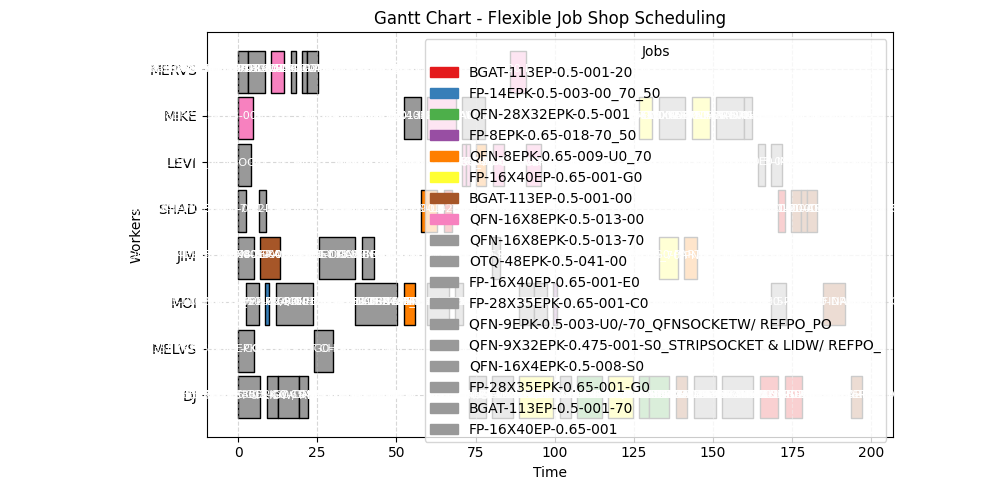

In [ ]:
env = FJSP_Env(
    jobs=jobs,
    workers=workers,
    processing_times=processing_times,
    deadlines=deadlines,
    switch_penalty=2,
    ongoing_tasks = ongoing_tasks,
    not_same_pic = not_same_pic
)

q_agent = QLearningAgent(env,heuristic='makespan')
q_agent.train(episodes=1000)

best_schedule, makespan = q_agent.get_best_schedule()
print(f"\nTotal Makespan: {makespan}")
display(pd.DataFrame(data=best_schedule, columns=['PN','Task','PIC','Start','Finish']))

# Display Gantt Chart
plot_gantt(best_schedule, env.workers)
pd.DataFrame(best_schedule, columns=['PN','Task','PIC','Start','Finish']).to_excel('schedule_ql_results.xlsx')

Episode 0: Total reward = -53621.68
Makespan: 216.25132050766265
Episode 0: Total reward = -100004.77
Makespan: 168.84102065403223
Episode 0: Total reward = -97710.47
Makespan: 147.5993226780539
Episode 0: Total reward = -72491.85
Makespan: 139.5287768246069
Episode 0: Total reward = -120743.98
Makespan: 157.2029726649081
Episode 0: Total reward = -69957.99
Makespan: 155.14537495799644
Episode 0: Total reward = -80580.99
Makespan: 154.30203771839905
Episode 0: Total reward = -97309.60
Makespan: 193.48790988610858
Episode 0: Total reward = -58923.85
Makespan: 172.0162409412706
Episode 0: Total reward = -172885.71
Makespan: 163.24958750205784
Mean Makespan: 166.7624564335096
Median Makespan: 160.22628008348295
Variance: 469.81618054560096


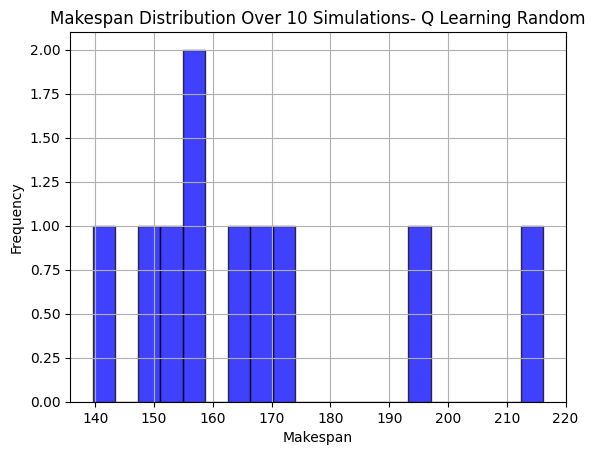

In [18]:
import matplotlib.pyplot as plt

def run_multiple_simulations(num_simulations=100, num_episodes=1000, heuristic='random'):
    makespans = []
    
    for _ in range(num_simulations):
        env = FJSP_Env(
            jobs=jobs,
            workers=workers,
            processing_times=processing_times,
            deadlines=deadlines,
            switch_penalty=2, 
            ongoing_tasks = ongoing_tasks,
            not_same_pic = not_same_pic
        )
        
        q_agent = QLearningAgent(env, heuristic=heuristic)
        q_agent.train(episodes=num_episodes)
        _, makespan = q_agent.get_best_schedule()
        print(f"Makespan: {makespan}")
        makespans.append(makespan)
    
    return makespans

# Run simulations
num_simulations = 10
makespan_results = run_multiple_simulations(num_simulations)

# Calculate statistics
mean_makespan = np.mean(makespan_results)
median_makespan = np.median(makespan_results)
variance_makespan = np.var(makespan_results)

print(f"Mean Makespan: {mean_makespan}")
print(f"Median Makespan: {median_makespan}")
print(f"Variance: {variance_makespan}")

# Plot histogram
plt.hist(makespan_results, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel("Makespan")
plt.ylabel("Frequency")
plt.title(f"Makespan Distribution Over {num_simulations} Simulations- Q Learning Random")
plt.grid(True)
plt.show()


Episode 0: Total reward = -20329.10
Makespan: 135.33644758997082
Episode 0: Total reward = -23703.77
Makespan: 151.85864429562494
Episode 0: Total reward = -23742.14
Makespan: 147.98763450450224
Episode 0: Total reward = -19439.24
Makespan: 164.7316502546038
Episode 0: Total reward = -24547.96
Makespan: 171.07662916578897
Episode 0: Total reward = -28667.63
Makespan: 123.96749319646511
Episode 0: Total reward = -22013.71
Makespan: 166.78144523117942
Episode 0: Total reward = -22953.85
Makespan: 131.06047285291606
Episode 0: Total reward = -20212.55
Makespan: 119.58745043710529
Episode 0: Total reward = -20828.66
Makespan: 150.44612276937954
Mean Makespan: 146.2833990297536
Median Makespan: 149.2168786369409
Variance: 298.8774730801773


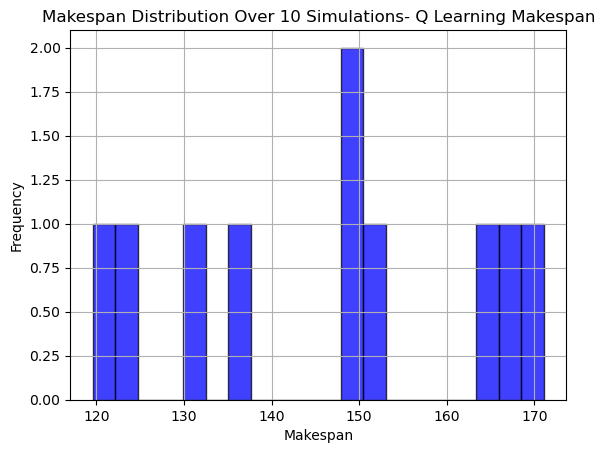

In [8]:
makespan_results = run_multiple_simulations(num_simulations, heuristic='makespan')

# Calculate statistics
mean_makespan = np.mean(makespan_results)
median_makespan = np.median(makespan_results)
variance_makespan = np.var(makespan_results)

print(f"Mean Makespan: {mean_makespan}")
print(f"Median Makespan: {median_makespan}")
print(f"Variance: {variance_makespan}")

# Plot histogram
plt.hist(makespan_results, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel("Makespan")
plt.ylabel("Frequency")
plt.title(f"Makespan Distribution Over {num_simulations} Simulations- Q Learning Makespan")
plt.grid(True)
plt.show()


Episode 0: Total reward = -21207.05
Makespan: 171.17822381901655
Episode 0: Total reward = -20864.87
Makespan: 114.09163535479728
Episode 0: Total reward = -18924.57
Makespan: 145.8452401558125
Episode 0: Total reward = -22074.78
Makespan: 141.22890137252585
Episode 0: Total reward = -19858.01
Makespan: 169.8944699359805
Episode 0: Total reward = -20097.92
Makespan: 148.5030909978955
Episode 0: Total reward = -24489.25
Makespan: 131.19368317971657
Episode 0: Total reward = -20102.99
Makespan: 204.1334706241322
Episode 0: Total reward = -20572.69
Makespan: 152.2448409513566
Episode 0: Total reward = -19783.93
Makespan: 187.85590865323312
Mean Makespan: 156.61694650444667
Median Makespan: 150.37396597462606
Variance: 651.4532201301557


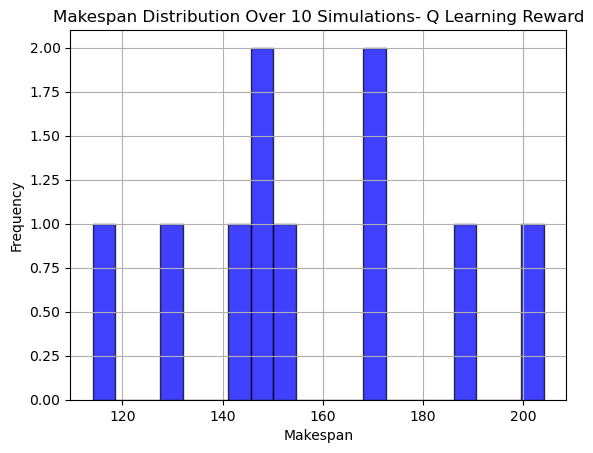

In [9]:
makespan_results = run_multiple_simulations(num_simulations, heuristic='reward')

# Calculate statistics
mean_makespan = np.mean(makespan_results)
median_makespan = np.median(makespan_results)
variance_makespan = np.var(makespan_results)

print(f"Mean Makespan: {mean_makespan}")
print(f"Median Makespan: {median_makespan}")
print(f"Variance: {variance_makespan}")

# Plot histogram
plt.hist(makespan_results, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel("Makespan")
plt.ylabel("Frequency")
plt.title(f"Makespan Distribution Over {num_simulations} Simulations- Q Learning Reward")
plt.grid(True)
plt.show()


#### Monte Carlo Tree Search

In [10]:
import numpy as np
import random
import math

class MCTSNode:
    def __init__(self, env, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = {}
        self.visits = 0
        self.total_reward = 0.0
        self.env = env
    
    def all_actions_explored(self):
        """Check if all possible actions have been explored."""
        return len(self.children) == len(set(self.env.get_possible_actions()))
    
    def best_child(self, exploration_weight=1.4):
        """Select the best child based on UCT score."""
        return max(self.children.values(), key=lambda child: child.uct_score(self.visits, exploration_weight))

    def uct_score(self, parent_visits, exploration_weight):
        """Compute the UCT score (Exploitation + Exploration)."""
        if self.visits == 0:
            return float('inf')  # Prioritize unexplored nodes
        exploitation = self.total_reward / self.visits
        exploration = exploration_weight * math.sqrt(math.log(parent_visits) / self.visits)
        return exploitation + exploration

    def expand(self):
        """Expand a child node with an untried action."""
        possible_actions = self.env.get_possible_actions()        
        random.shuffle(possible_actions)  # Prevent bias
        for action in possible_actions:
            if action not in self.children:
                env_copy = self.env.create_copy()
                _, _, _ = env_copy.step(action)
                new_state = env_copy.get_state()
                self.children[action] = MCTSNode(env_copy, new_state, parent=self, action=action)
                return self.children[action] 
        return None    

   

    def update(self, reward):
        """Backpropagate the reward up the tree."""
        self.visits += 1
        self.total_reward += reward
        if self.parent:
            self.parent.update(reward)

class MCTSAgent:
    def __init__(self, env,
                 iterations=4000,
                 num_walk = 1000,
                 exploration_weight=1.4,
                 heuristic='random'):
        
        assert heuristic in ['random', 'makespan','reward'], "heuristic must be 'random','makespan', or 'reward'"
        
        self.heuristic = heuristic
        self.env = env
        self.iterations = iterations
        self.exploration_weight = exploration_weight
        self.num_walk = num_walk

    def get_action_best_makespan(self, actions):
        results = {}
        for action in actions:
            env_copy = self.env.create_copy()
            env_copy.step(action)
            results[action] = env_copy.current_time        
        return min(results, key=results.get)

    def get_action_best_reward(self, actions):
        results = {}
        for action in actions:
            env_copy = self.env.create_copy()
            _, reward, _ =env_copy.step(action)
            results[action] = reward
        return max(results, key=results.get)
    
    def search(self, state):
        root = MCTSNode(self.env.create_copy(), state)
        
        for _ in range(self.iterations):
            node = root
            
            # Selection
            while node.all_actions_explored() and node.children:
                node = node.best_child(self.exploration_weight)
            
            # Expansion
            new_node = node.expand()
            if new_node:
                node = new_node
            
            # Simulation
            env_copy = node.env.create_copy()
            total_reward = 0
            gamma = 1.0
            discount_factor = 0.99
            
            for _ in range(self.num_walk):
                actions = env_copy.get_possible_actions()
                if not actions:
                    break

                if self.heuristic == 'random':                    
                    action = random.choice(actions)
                elif self.heuristic == 'makespan':
                    action = self.get_action_best_makespan(actions)
                elif self.heuristic == 'reward':
                    action = self.get_action_best_reward(actions)
                                
                action = random.choice(actions)
                _, reward, done = env_copy.step(action)
                total_reward += gamma * reward
                gamma *= discount_factor
                if done:
                    break
            
            # Backpropagation
            node.update(total_reward)
    

        if not root.children:
            return None
        return root.best_child(0).action


    def act(self):
        return self.search(self.env.get_state())

    def get_best_schedule(self):
        state = self.env.reset()
    
        possible_actions = self.env.get_possible_actions()
        print(f"[Debug] Initial possible actions: {len(possible_actions)}")
        if not possible_actions:
            print("[Error] No possible actions available at the start. Check environment setup.")
            return [], 0
    
        done = False
        while not done:
            action = self.act()
            if action is None:
                print("[Warning] MCTS returned no action. Ending early.")
                break
            state, _, done = self.env.step(action)
        return self.env.schedule, self.env.current_time


#### MCTS with Random Heuristic

[Debug] Initial possible actions: 69
Final Makespan: 67.70166900211056


,PN,Task,PIC,Start,Finish
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.000000,7.000000
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.000000,4.000000
2,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-3D CONCEPT,LEVI,6.000000,15.394382
3,FP-16X40EP-0.65-001-E0,FP-16X40EP-0.65-001-E0-3D CONCEPT,MOI,0.000000,8.686852
4,FP-28X35EPK-0.65-001-C0,FP-28X35EPK-0.65-001-C0-CONCEPT CHECKING,MELVS,0.000000,4.533376
...,...,...,...,...,...
66,OTQ-48EPK-0.5-041-00,OTQ-48EPK-0.5-041-00-MESLINK,DJ,56.337616,58.909169
67,BGAT-113EP-0.5-001-00,BGAT-113EP-0.5-001-00-DRAWING - 2D&3D PARTS,SHAD,56.628821,61.913463
68,QFN-16X8EPK-0.5-013-00,QFN-16X8EPK-0.5-013-00-PARTS INITIAL CHECKING,MERVS,52.352066,56.346705
69,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-PARTS INITIAL CHECKING,MIKE,56.543145,64.174708


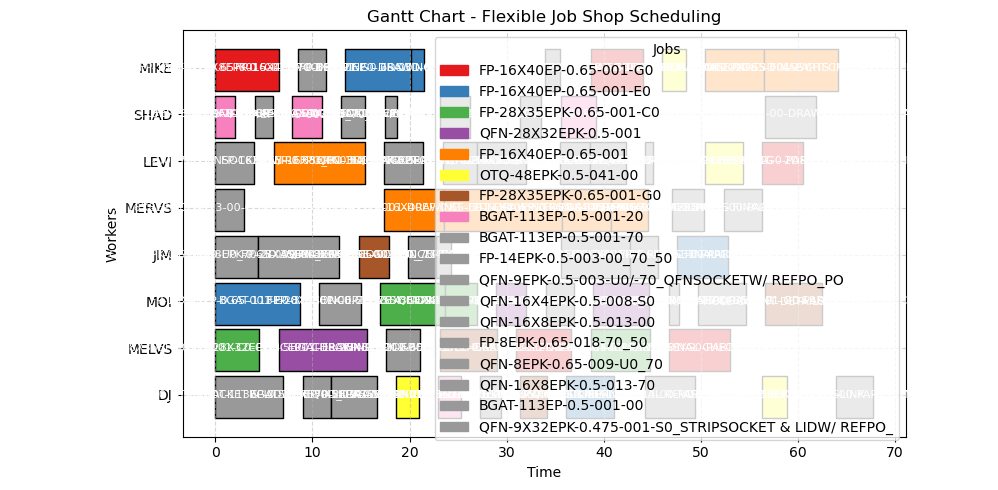

In [11]:
env = FJSP_Env(
    jobs=jobs,
    workers=workers,
    processing_times=processing_times,
    deadlines=deadlines,
    switch_penalty=2,
    ongoing_tasks = ongoing_tasks,
    not_same_pic = not_same_pic
)

# Run MCTS
mcts_agent = MCTSAgent(env)
best_schedule, makespan = mcts_agent.get_best_schedule()
print("Final Makespan:", makespan)
display(pd.DataFrame(data=best_schedule, columns=['PN','Task','PIC','Start','Finish']))
plot_gantt(best_schedule, env.workers)

pd.DataFrame(best_schedule, columns=['PN','Task','PIC','Start','Finish']).to_excel('schedule_mcts_results.xlsx')

#### MCTS with Makespan Heuristic

In [12]:
env = FJSP_Env(
    jobs=jobs,
    workers=workers,
    processing_times=processing_times,
    deadlines=deadlines,
    switch_penalty=2,
    ongoing_tasks = ongoing_tasks,
    not_same_pic = not_same_pic
)

# Run MCTS
mcts_agent = MCTSAgent(env, heuristic='makespan')
best_schedule, makespan = mcts_agent.get_best_schedule()
print("Final Makespan:", makespan)
display(pd.DataFrame(data=best_schedule, columns=['PN','Task','PIC','Start','Finish']))

[Debug] Initial possible actions: 69
Final Makespan: 67.64274612889616


,PN,Task,PIC,Start,Finish
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.000000,7.000000
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.000000,4.000000
2,BGAT-113EP-0.5-001-00,BGAT-113EP-0.5-001-00-2D ASSY CONCEPT,JIM,0.000000,4.840491
3,FP-14EPK-0.5-003-00_70_50,FP-14EPK-0.5-003-00_70_50-PN/PIN HOLE COUNT DE...,SHAD,0.000000,1.263156
4,QFN-28X32EPK-0.5-001,QFN-28X32EPK-0.5-001-DRAWING - 2D&3D ASSY,MELVS,0.000000,9.044084
...,...,...,...,...,...
66,BGAT-113EP-0.5-001-00,BGAT-113EP-0.5-001-00-DRAWING - 2D&3D PARTS,JIM,46.599914,57.653326
67,FP-16X40EP-0.65-001-G0,FP-16X40EP-0.65-001-G0-PARTS INITIAL CHECKING,MIKE,51.254001,56.764860
68,QFN-16X8EPK-0.5-013-00,QFN-16X8EPK-0.5-013-00-PARTS FINAL CHECKING,MIKE,58.764860,62.747789
69,BGAT-113EP-0.5-001-00,BGAT-113EP-0.5-001-00-PARTS FINAL CHECKING,MOI,59.653326,63.395185


#### MCTS with Reward Heuristic

In [13]:
env = FJSP_Env(
    jobs=jobs,
    workers=workers,
    processing_times=processing_times,
    deadlines=deadlines,
    switch_penalty=2,
    ongoing_tasks = ongoing_tasks,
    not_same_pic = not_same_pic
)

# Run MCTS
mcts_agent = MCTSAgent(env, heuristic='reward')
best_schedule, makespan = mcts_agent.get_best_schedule()
print("Final Makespan:", makespan)
display(pd.DataFrame(data=best_schedule, columns=['PN','Task','PIC','Start','Finish']))

[Debug] Initial possible actions: 69
Final Makespan: 60.23866231693334


,PN,Task,PIC,Start,Finish
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.000000,7.000000
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.000000,4.000000
2,QFN-28X32EPK-0.5-001,QFN-28X32EPK-0.5-001-DRAWING - 2D&3D ASSY,MELVS,0.000000,9.044084
3,FP-14EPK-0.5-003-00_70_50,FP-14EPK-0.5-003-00_70_50-PN/PIN HOLE COUNT DE...,SHAD,0.000000,1.263156
4,FP-28X35EPK-0.65-001-C0,FP-28X35EPK-0.65-001-C0-CONCEPT CHECKING,JIM,0.000000,3.103245
...,...,...,...,...,...
66,QFN-16X8EPK-0.5-013-00,QFN-16X8EPK-0.5-013-00-PARTS INITIAL CHECKING,MERVS,54.048014,58.042652
67,BGAT-113EP-0.5-001-00,BGAT-113EP-0.5-001-00-PARTS FINAL CHECKING,JIM,47.174563,50.909978
68,QFN-8EPK-0.65-009-U0_70,QFN-8EPK-0.65-009-U0_70-PN/PIN HOLE COUNT DETAILS,SHAD,52.785174,54.111611
69,FP-16X40EP-0.65-001-G0,FP-16X40EP-0.65-001-G0-PARTS INITIAL CHECKING,MIKE,50.855268,56.366127


#### Greedy Algorithm

In [65]:
df_predict_takt = df_target.copy()

In [19]:
class GreedyAgent:
    def __init__(self, env):
        self.env = env

    def choose_action(self):
        actions = self.env.get_possible_actions()
        if not actions:
            return None

        results = {}
        for action in actions:
            env_copy = self.env.create_copy()
            env_copy.step(action)
            results[action] = env_copy.current_time
        
        return min(results, key=results.get)   

    def get_best_schedule(self):
        state = self.env.reset()
        done = False
        while not done:
            action = self.choose_action()
            if action is None:
                break
            state, _, done = self.env.step(action)
        return self.env.schedule, self.env.current_time    

Final Makespan: 94.20675412860793


,PN,Task,PIC,Start,Finish
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.000000,7.000000
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.000000,4.000000
2,FP-28X35EPK-0.65-001-C0,FP-28X35EPK-0.65-001-C0-CONCEPT CHECKING,MELVS,0.000000,5.157667
3,FP-28X35EPK-0.65-001-G0,FP-28X35EPK-0.65-001-G0-CONCEPT CHECKING,MOI,0.000000,4.506442
4,BGAT-113EP-0.5-001-00,BGAT-113EP-0.5-001-00-2D ASSY CONCEPT,JIM,0.000000,6.032175
...,...,...,...,...,...
66,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-DRAWING - 2D&3D PARTS,MIKE,54.896169,67.724496
67,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-INTERNAL REVISION,MOI,67.724496,72.970233
68,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-MESLINK,MIKE,72.970233,78.643671
69,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-PARTS FINAL CHECKING,MOI,78.643671,87.391111


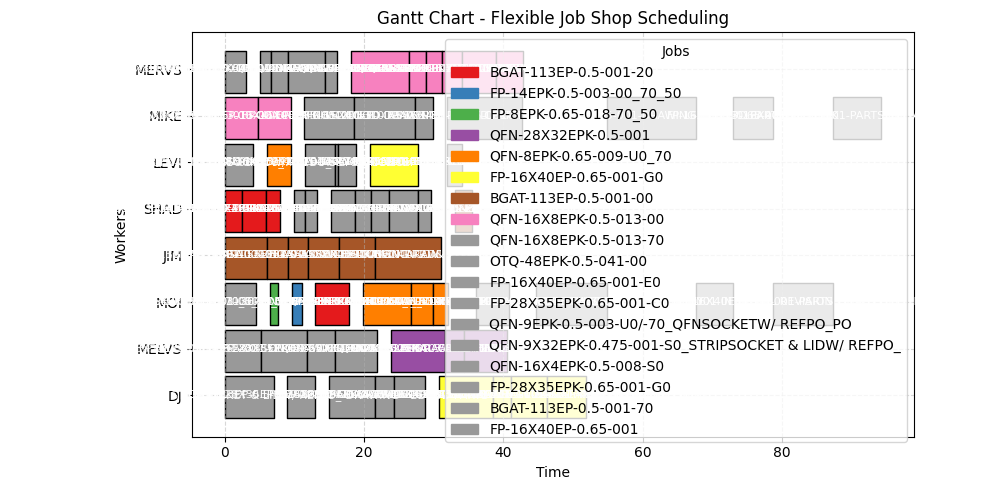

In [20]:
env = FJSP_Env(
    jobs=jobs,
    workers=workers,
    processing_times=processing_times,
    deadlines=deadlines,
    switch_penalty=2,
    ongoing_tasks = ongoing_tasks,
    not_same_pic = not_same_pic
)

greedy_agent = GreedyAgent(env)
best_schedule, makespan = greedy_agent.get_best_schedule()

print("Final Makespan:", makespan)
display(pd.DataFrame(best_schedule, columns=['PN','Task','PIC','Start','Finish']))
pd.DataFrame(best_schedule, columns=['PN','Task','PIC','Start','Finish']).to_excel('schedule_greedy_results.xlsx')
plot_gantt(best_schedule, env.workers)


#### Genetic Algorithm

In [21]:
import random

class GeneticAlgorithmSolver:
    def __init__(self, env, population_size=50, generations=100, crossover_rate=0.8, mutation_rate=0.2):
        self.env = env
        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            individual = self.random_individual()
            population.append(individual)
        return population

    def random_individual(self):
        task_list = [(job, sub) for job, subs in self.env.jobs.items() for sub in subs]
        random.shuffle(task_list)
        individual = []
        for job, sub in task_list:
            eligible_workers = list(self.env.processing_times[sub].keys())
            worker = random.choice(eligible_workers)
            individual.append((job, sub, worker))
        return individual

    def evaluate_fitness(self, individual):
        env_copy = self.env.create_copy()
        remaining_actions = individual[:]
        progress = True

        # Keep scheduling valid actions until no more progress
        while remaining_actions and progress:
            progress = False
            next_actions = []
            for action in remaining_actions:
                if env_copy.is_valid_action(*action):
                    env_copy.step(action)
                    progress = True
                else:
                    next_actions.append(action)
            remaining_actions = next_actions

        # Penalize individuals that did not complete all tasks
        total_tasks = sum(len(v) for v in self.env.jobs.values())
        completed_tasks = len(env_copy.completed_jobs)
        uncompleted_penalty = (total_tasks - completed_tasks) * 1000
        makespan = env_copy.current_time

        return 1 / (1 + makespan + uncompleted_penalty)

    def selection(self, population, fitnesses):
        total_fitness = sum(fitnesses)
        if total_fitness == 0:
            return random.sample(population, 2)
        return random.choices(population, weights=fitnesses, k=2)

    def crossover(self, parent1, parent2):
        cut = random.randint(1, len(parent1) - 2)
        child1 = parent1[:cut] + [gene for gene in parent2 if gene not in parent1[:cut]]
        child2 = parent2[:cut] + [gene for gene in parent1 if gene not in parent2[:cut]]
        return child1, child2

    def mutate(self, individual):
        new_individual = individual[:]
        if random.random() < 0.5:
            # Swap mutation
            i, j = random.sample(range(len(new_individual)), 2)
            new_individual[i], new_individual[j] = new_individual[j], new_individual[i]
        else:
            # Worker reassignment
            i = random.randint(0, len(new_individual) - 1)
            job, sub, _ = new_individual[i]
            eligible_workers = list(self.env.processing_times[sub].keys())
            new_worker = random.choice(eligible_workers)
            new_individual[i] = (job, sub, new_worker)
        return new_individual

    def solve(self):
        population = self.initialize_population()
        for _ in range(self.generations):
            fitnesses = [self.evaluate_fitness(ind) for ind in population]
            new_population = []
            while len(new_population) < self.population_size:
                parent1, parent2 = self.selection(population, fitnesses)
                if random.random() < self.crossover_rate:
                    child1, child2 = self.crossover(parent1, parent2)
                else:
                    child1, child2 = parent1[:], parent2[:]
                if random.random() < self.mutation_rate:
                    child1 = self.mutate(child1)
                if random.random() < self.mutation_rate:
                    child2 = self.mutate(child2)
                new_population.extend([child1, child2])
            population = new_population[:self.population_size]

        best_individual = max(population, key=self.evaluate_fitness)

        # Apply best schedule using the same logic
        env_copy = self.env.create_copy()
        remaining_actions = best_individual[:]
        progress = True
        while remaining_actions and progress:
            progress = False
            next_actions = []
            for action in remaining_actions:
                if env_copy.is_valid_action(*action):
                    env_copy.step(action)
                    progress = True
                else:
                    next_actions.append(action)
            remaining_actions = next_actions

        return env_copy.schedule, env_copy.current_time


Total Makespan: 98.25901802077084


,PN,Task,PIC,Start,Finish
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.000000,7.000000
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.000000,4.000000
2,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-3D CONCEPT,MIKE,0.000000,10.715229
3,FP-16X40EP-0.65-001-E0,FP-16X40EP-0.65-001-E0-3D CONCEPT,MOI,0.000000,8.581430
4,FP-28X35EPK-0.65-001-C0,FP-28X35EPK-0.65-001-C0-CONCEPT CHECKING,DJ,9.000000,12.751086
...,...,...,...,...,...
66,BGAT-113EP-0.5-001-70,BGAT-113EP-0.5-001-70-PARTS FINAL CHECKING,SHAD,90.306374,92.227742
67,QFN-16X8EPK-0.5-013-00,QFN-16X8EPK-0.5-013-00-PARTS FINAL CHECKING,MIKE,84.880450,89.443375
68,FP-16X40EP-0.65-001-E0,FP-16X40EP-0.65-001-E0-PARTS FINAL CHECKING,JIM,80.956793,86.964233
69,QFN-16X8EPK-0.5-013-00,QFN-16X8EPK-0.5-013-00-PARTS INITIAL CHECKING,DJ,91.443375,95.978807


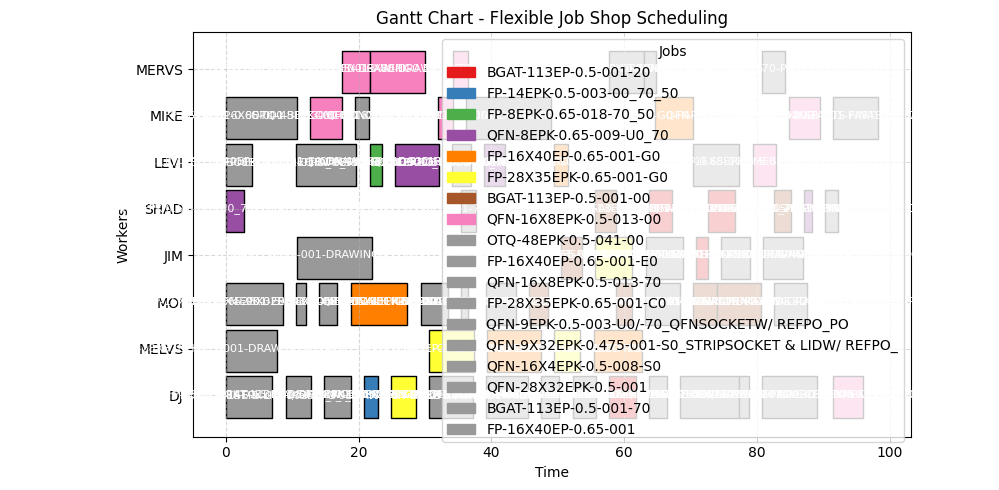

In [22]:
env = FJSP_Env(
    jobs=jobs,
    workers=workers,
    processing_times=processing_times,
    deadlines=deadlines,
    switch_penalty=2,
    ongoing_tasks = ongoing_tasks,
    not_same_pic = not_same_pic
)

ga_solver = GeneticAlgorithmSolver(env)
schedule, makespan = ga_solver.solve()

print(f"Total Makespan: {makespan}")
display(pd.DataFrame(schedule, columns=['PN','Task','PIC','Start','Finish']))


plot_gantt(schedule, env.workers)

pd.DataFrame(schedule, columns=['PN','Task','PIC','Start','Finish']).to_excel('schedule_ga_results.xlsx')

In [23]:
import matplotlib.pyplot as plt

def run_multiple_simulations(q_agent, num_simulations=100):
    makespans = []
    
    for _ in range(num_simulations):
        env = FJSP_Env(
            jobs=jobs,
            workers=workers,
            processing_times=processing_times,
            deadlines=deadlines,
            switch_penalty=2,
            ongoing_tasks = ongoing_tasks,
            not_same_pic = not_same_pic
        )
        
        ga_solver = GeneticAlgorithmSolver(env)
        schedule, makespan = ga_solver.solve()
        print(f"Makespan: {makespan}")
        makespans.append([schedule, makespan])
    
    return makespans

# Run simulations
num_simulations = 20
makespan_results = run_multiple_simulations(q_agent, num_simulations)

Makespan: 101.18067041388984
Makespan: 96.58218978999642
Makespan: 101.13843839014635
Makespan: 103.72143629325763
Makespan: 90.94505441579359
Makespan: 94.37102894938667
Makespan: 106.97302871274846
Makespan: 98.24797293220026
Makespan: 103.93574752239248
Makespan: 101.46071600292895
Makespan: 97.73340724250515
Makespan: 94.71905311101041
Makespan: 103.00325858052294
Makespan: 97.49199845667293
Makespan: 115.36690911744437
Makespan: 103.37411400744722
Makespan: 91.89818294140129
Makespan: 107.87508586024467
Makespan: 115.8674389133113
Makespan: 109.64472636350831


Mean Makespan: 101.77652290084048
Median Makespan: 101.3206932084094
Variance: 45.82042743454278


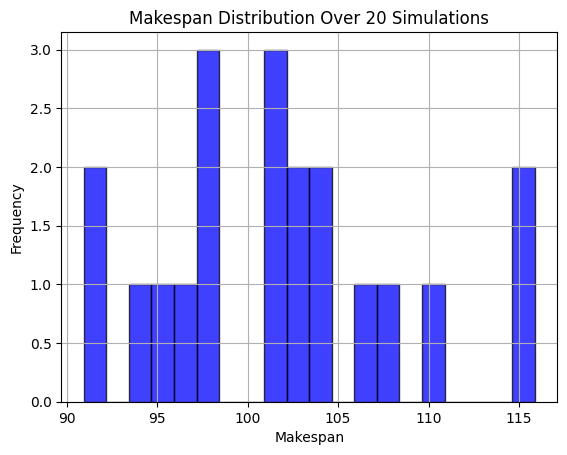

In [24]:
# Calculate statistics
makespans = [x[1] for x in makespan_results]
mean_makespan = np.mean(makespans)
median_makespan = np.median(makespans)
variance_makespan = np.var(makespans)

print(f"Mean Makespan: {mean_makespan}")
print(f"Median Makespan: {median_makespan}")
print(f"Variance: {variance_makespan}")

# Plot histogram
plt.hist(makespans, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel("Makespan")
plt.ylabel("Frequency")
plt.title(f"Makespan Distribution Over {num_simulations} Simulations")
plt.grid(True)
plt.show()

Total Makespan: 90.94505441579359


,PN,Task,PIC,Start,Finish
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.000000,7.000000
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.000000,4.000000
2,QFN-16X8EPK-0.5-013-70,QFN-16X8EPK-0.5-013-70-DRAWING - 2D&3D ASSY,LEVI,6.000000,8.871133
3,FP-8EPK-0.65-018-70_50,FP-8EPK-0.65-018-70_50-PN/PIN HOLE COUNT DETAILS,DJ,9.000000,10.941995
4,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-3D CONCEPT,MIKE,0.000000,10.715229
...,...,...,...,...,...
66,FP-16X40EP-0.65-001-G0,FP-16X40EP-0.65-001-G0-PARTS FINAL CHECKING,MELVS,72.232596,79.498316
67,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-PARTS INITIAL CHECKING,MOI,72.914447,81.203447
68,FP-16X40EP-0.65-001-G0,FP-16X40EP-0.65-001-G0-PARTS INITIAL CHECKING,LEVI,83.182985,88.448948
69,BGAT-113EP-0.5-001-00,BGAT-113EP-0.5-001-00-DRAWING - 2D&3D PARTS,SHAD,81.110829,86.599814


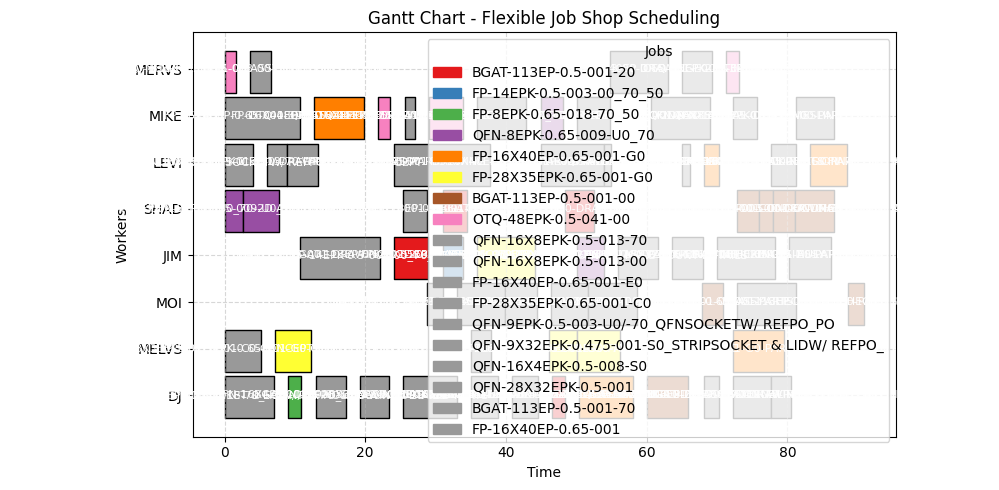

In [25]:
schedule, makespan = min(makespan_results, key=lambda x: x[1])

print(f"Total Makespan: {makespan}")
display(pd.DataFrame(schedule, columns=['PN','Task','PIC','Start','Finish']))


plot_gantt(schedule, env.workers)

#### Human Agent
- user can do task assignments
- can be used for manual setting of engineers and seeing the resulting schedule

In [26]:
class HumanAgent:
    def __init__(self, env, task_assignments):
        self.env = env
        self.task_assignments = task_assignments

    def get_schedule(self):
        state = self.env.reset()
        done = False

        while not done:
            tasks_for_assignment = self.env.get_tasks_for_assignment()
            if not tasks_for_assignment:
                break

            for job, sub_job in tasks_for_assignment:
                if sub_job not in self.task_assignments:
                    print(f'No worker assigned for task {sub_job}')
                    done = True
                    break

                assigned_pic = self.task_assignments[sub_job]

                if sub_job not in self.env.processing_times or assigned_pic not in self.env.processing_times[sub_job]:
                    print(f'No processing time set for worker {assigned_pic} for task {sub_job}.')
                    done = True
                    break

                if hasattr(self.env, "not_same_pic") and sub_job in self.env.not_same_pic:
                    prev_task = self.env.not_same_pic[sub_job]
                    prev_worker = self.task_assignments.get(prev_task)
                    if prev_worker == assigned_pic:
                        print(f'Same worker {assigned_pic} assigned for {prev_task} and {sub_job}.')
                        done = True
                        break

                state, _, done = self.env.step((job, sub_job, assigned_pic))

        return self.env.schedule, self.env.current_time

No processing time set for worker MERVS for task FP-16X40EP-0.65-001-3D CONCEPT.
Final Makespan: 14.903835959188845


,PN,Task,PIC,Start,Finish
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.000000,7.000000
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.000000,4.000000
2,QFN-28X32EPK-0.5-001,QFN-28X32EPK-0.5-001-DRAWING - 2D&3D ASSY,MELVS,0.000000,7.746169
3,FP-28X35EPK-0.65-001-C0,FP-28X35EPK-0.65-001-C0-CONCEPT CHECKING,MELVS,9.746169,14.903836
4,FP-28X35EPK-0.65-001-G0,FP-28X35EPK-0.65-001-G0-CONCEPT CHECKING,MOI,0.000000,4.506442
5,BGAT-113EP-0.5-001-00,BGAT-113EP-0.5-001-00-2D ASSY CONCEPT,JIM,0.000000,6.032175
6,BGAT-113EP-0.5-001-20,BGAT-113EP-0.5-001-20-2D ASSY CONCEPT,SHAD,0.000000,2.488938
7,BGAT-113EP-0.5-001-70,BGAT-113EP-0.5-001-70-2D ASSY CONCEPT,DJ,9.000000,13.027043
8,QFN-16X4EPK-0.5-008-S0,QFN-16X4EPK-0.5-008-S0-ASSY CHECKING,MOI,6.506442,8.009030
9,FP-14EPK-0.5-003-00_70_50,FP-14EPK-0.5-003-00_70_50-PN/PIN HOLE COUNT DE...,JIM,8.032175,10.999379


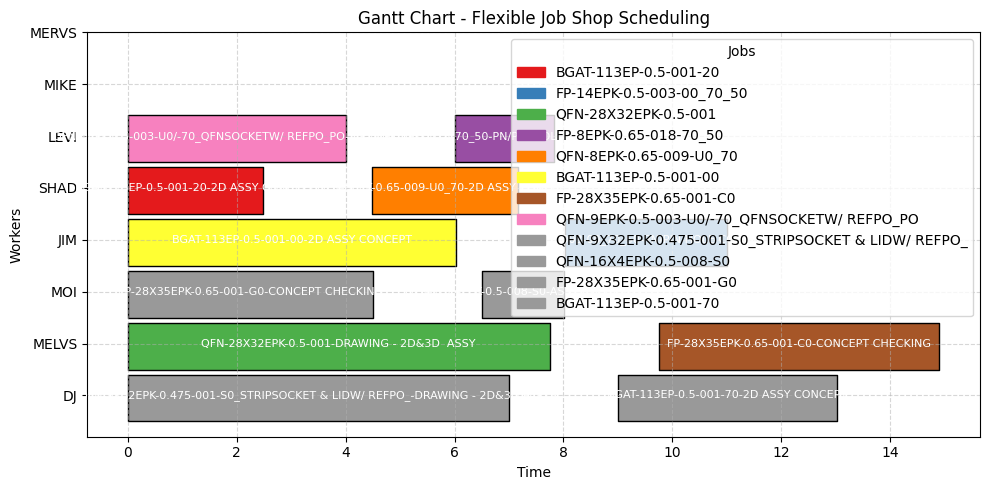

In [27]:
env = FJSP_Env(
    jobs=jobs,
    workers=workers,
    processing_times=processing_times,
    deadlines=deadlines,
    switch_penalty=2,
    ongoing_tasks = ongoing_tasks,
    not_same_pic = not_same_pic
)

df_task_assignments = pd.read_excel("sample_schedule.xlsx", sheet_name="Sheet3")
task_assignments = df_task_assignments.set_index('PN Task')['PIC'].to_dict()


human_agent = HumanAgent(env, task_assignments=task_assignments)
best_schedule, makespan = human_agent.get_schedule()

print("Final Makespan:", makespan)
display(pd.DataFrame(best_schedule, columns=['PN','Task','PIC','Start','Finish']))
plot_gantt(best_schedule, env.workers)
pd.DataFrame(best_schedule, columns=['PN','Task','PIC','Start','Finish']).to_excel('schedule_human_results.xlsx')

In [76]:
df = pd.read_excel("schedule_greedy_results.xlsx")

In [78]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


# Add a duration column
df['Duration'] = df['Finish'] - df['Start']

def add_business_days(start_date, hours):
    """
    Add business hours to a date, skipping weekends and considering 6 effective hours per day
    """
    effective_hours_per_day = 6
    current_date = start_date.replace(hour=8, minute=0, second=0, microsecond=0)
    
    # Skip to Monday if start date is on weekend
    if current_date.weekday() >= 5:  # 5=Saturday, 6=Sunday
        days_to_add = 7 - current_date.weekday() + 0  # Add days to reach Monday
        current_date = current_date + timedelta(days=days_to_add)
    
    days = int(hours // effective_hours_per_day)
    remaining_hours = hours % effective_hours_per_day
    
    # Add full business days
    for _ in range(days):
        current_date = current_date + timedelta(days=1)
        # Skip weekends
        while current_date.weekday() >= 5:
            current_date = current_date + timedelta(days=1)
    
    # Add remaining hours
    hours_to_add = int(remaining_hours)
    minutes_to_add = int((remaining_hours - hours_to_add) * 60)
    
    return current_date + timedelta(hours=hours_to_add, minutes=minutes_to_add)

# Calculate dates using today as the starting point
def calculate_schedule(dataframe, start_date):
    results = []
    base_date = start_date.replace(hour=8, minute=0, second=0, microsecond=0)
    
    for _, row in dataframe.iterrows():
        # Calculate start date
        start_hours = row['Start']
        task_start_date = add_business_days(base_date, start_hours)
        
        # Calculate finish date
        duration_hours = row['Duration']
        task_end_date = add_business_days(task_start_date, duration_hours)
        
        # Calculate business days between
        business_days = 0
        temp_date = task_start_date
        while temp_date.date() < task_end_date.date():
            if temp_date.weekday() < 5:  # Not a weekend
                business_days += 1
            temp_date = temp_date + timedelta(days=1)
            
        # Add one more day if end time is not at start of day
        if task_end_date.hour > 8 or task_end_date.minute > 0:
            if task_end_date.weekday() < 5:  # Not a weekend
                business_days += 1
        
        results.append({
            'PN': row['PN'],
            'Task': row['Task'],
            'PIC': row['PIC'],
            'Start_Hours': row['Start'],
            'Finish_Hours': row['Finish'],
            'Duration_Hours': row['Duration'],
            'Start_Date': task_start_date,
            'End_Date': task_end_date,
            'Business_Days': business_days
        })
    
    return pd.DataFrame(results)

# Use today's date as the starting point
today = datetime(2025, 5, 19)  # May 19, 2025 (Monday)
schedule_df = calculate_schedule(df, today)

# Format dates for display
schedule_df['Start_Date_Formatted'] = schedule_df['Start_Date'].dt.strftime('%Y-%m-%d %H:%M')
schedule_df['End_Date_Formatted'] = schedule_df['End_Date'].dt.strftime('%Y-%m-%d %H:%M')

# Display the results
print("\nProject Schedule:")
result_df = schedule_df[['PN', 'Task', 'PIC', 'Start_Hours', 'Finish_Hours', 
                         'Start_Date_Formatted', 'End_Date_Formatted', 'Business_Days']]

# Print results in a nice format
print(result_df.to_string(index=False))

# Create a summary of projects with total days
project_summary = schedule_df.groupby('PN').agg(
    Total_Hours=('Duration_Hours', 'sum'),
    Min_Start_Date=('Start_Date', 'min'),
    Max_End_Date=('End_Date', 'max')
)

# Calculate business days for each project
project_summary['Total_Business_Days'] = project_summary.apply(
    lambda row: (row['Max_End_Date'] - row['Min_Start_Date']).days + 1, axis=1
)

# Format dates for the summary
project_summary['Start_Date'] = project_summary['Min_Start_Date'].dt.strftime('%Y-%m-%d %H:%M')
project_summary['End_Date'] = project_summary['Max_End_Date'].dt.strftime('%Y-%m-%d %H:%M')

# Display the project summary
print("\nProject Summary (Total Duration):")
summary_result = project_summary[['Total_Hours', 'Start_Date', 'End_Date', 'Total_Business_Days']]
print(summary_result.to_string())

# You can also export to Excel/CSV
# schedule_df.to_excel("project_schedule.xlsx", index=False)
project_summary.to_csv("project_summary2.csv")


Project Schedule:
                                                 PN                                                                      Task   PIC  Start_Hours  Finish_Hours Start_Date_Formatted End_Date_Formatted  Business_Days
QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ REFPO_ QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ REFPO_-DRAWING - 2D&3D PARTS    DJ     0.000000      7.000000     2025-05-19 08:00   2025-05-20 09:00              2
       QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO                   QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3D CONCEPT  LEVI     0.000000      4.000000     2025-05-19 08:00   2025-05-19 12:00              1
                            FP-28X35EPK-0.65-001-C0                                  FP-28X35EPK-0.65-001-C0-CONCEPT CHECKING MELVS     0.000000      4.465559     2025-05-19 08:00   2025-05-19 12:27              1
                            FP-28X35EPK-0.65-001-G0                                  FP-28X35EPK-0.65-001-G0-CONCEPT CHECKING

In [54]:
project_summary.columns

Index(['Total_Hours', 'Min_Start_Date', 'Max_End_Date', 'Total_Business_Days',
       'Start_Date', 'End_Date'],
      dtype='object')

In [79]:
result_df.head(5)

,PN,Task,PIC,Start_Hours,Finish_Hours,Start_Date_Formatted,End_Date_Formatted,Business_Days
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.0,7.000000,2025-05-19 08:00,2025-05-20 09:00,2
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.0,4.000000,2025-05-19 08:00,2025-05-19 12:00,1
2,FP-28X35EPK-0.65-001-C0,FP-28X35EPK-0.65-001-C0-CONCEPT CHECKING,MELVS,0.0,4.465559,2025-05-19 08:00,2025-05-19 12:27,1
3,FP-28X35EPK-0.65-001-G0,FP-28X35EPK-0.65-001-G0-CONCEPT CHECKING,MOI,0.0,2.954094,2025-05-19 08:00,2025-05-19 10:57,1
4,BGAT-113EP-0.5-001-00,BGAT-113EP-0.5-001-00-2D ASSY CONCEPT,JIM,0.0,5.188081,2025-05-19 08:00,2025-05-19 13:11,1


In [80]:
result_df.to_csv("schedule_with_dates.csv")
